In [19]:
import torch
from pathlib import Path
from pykeen.triples import TriplesFactory
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.decomposition import PCA


In [ ]:
model_dir = Path('C3_experiments/RotatE_d256_n5') 
model = torch.load(model_dir / 'trained_model.pkl', weights_only=False)
tf = TriplesFactory.from_path_binary(model_dir / 'training_triples')

entity_emb = model.entity_representations[0]().detach().cpu()
ent2id = tf.entity_to_id
id2ent = {v: k for k, v in ent2id.items()}

In [3]:
author_ids = [idx for ent, idx in ent2id.items() if isinstance(ent, str) and 'author' in ent]
author_labels = [id2ent[idx] for idx in author_ids]
author_vectors = entity_emb[author_ids]
author_vectors_np = author_vectors.detach().cpu().numpy() if hasattr(author_vectors, 'detach') else np.array(author_vectors)
author_vectors_real = np.concatenate([author_vectors_np.real, author_vectors_np.imag], axis=1)

Author Clustering

In [11]:
sil_scores = []
for k in k_range[1:]:  # silhouette_score needs at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(author_vectors_real)
    sil = silhouette_score(author_vectors_real, labels)
    sil_scores.append(sil)



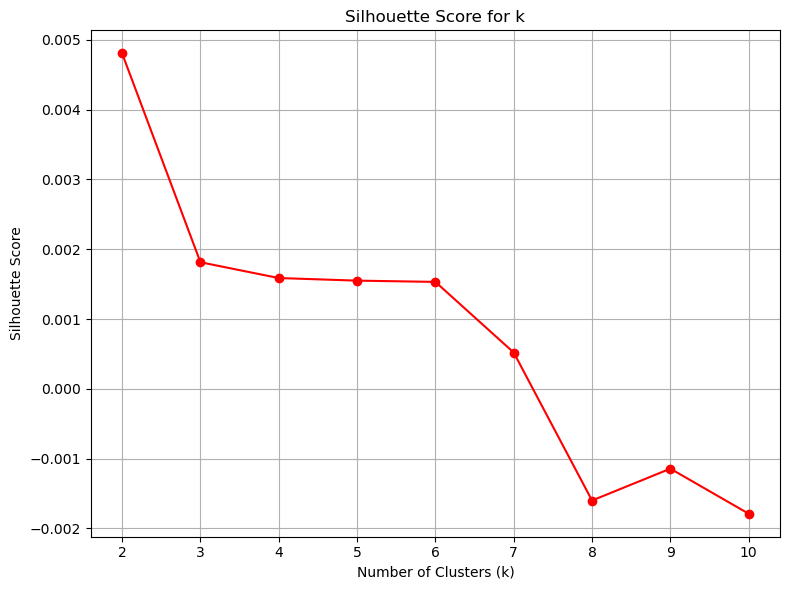

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(k_range[1:], sil_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for k')
plt.grid(True)
plt.tight_layout()
plt.savefig('silhouette_plot.png')
plt.show()

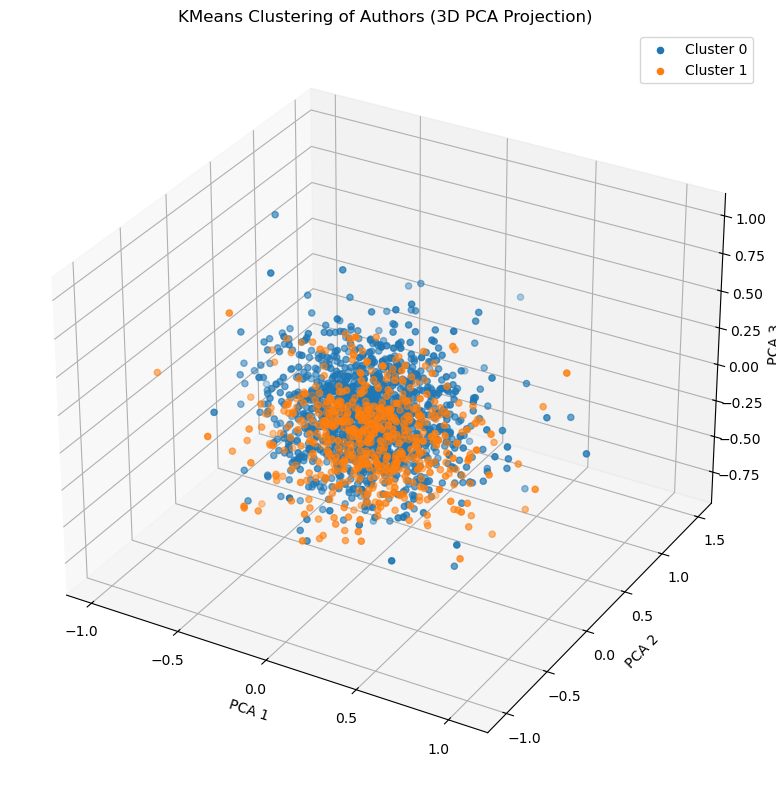

In [21]:
n_clusters = 2
pca3d = PCA(n_components=3)
reduced3d = pca3d.fit_transform(author_vectors_real)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_clusters):
    ax.scatter(
        reduced3d[cluster_labels == i, 0],
        reduced3d[cluster_labels == i, 1],
        reduced3d[cluster_labels == i, 2],
        label=f'Cluster {i}'
    )
ax.set_title('KMeans Clustering of Authors (3D PCA Projection)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()
plt.tight_layout()
plt.savefig('author_clusters_3d.png')
plt.show()

Anomaly Detection: Find the outliers of authors

In [22]:
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(author_vectors_real)
pred = clf.predict(author_vectors_real)
anomalies = [author_labels[i] for i, p in enumerate(pred) if p == -1]
print(f"Detected {len(anomalies)} anomalous authors:")
for a in anomalies:
    print(f" - {a}")

Detected 98 anomalous authors:
 - http://example.org/research#author10372032
 - http://example.org/research#author111658864
 - http://example.org/research#author112215923
 - http://example.org/research#author117124291
 - http://example.org/research#author119225182
 - http://example.org/research#author120908459
 - http://example.org/research#author123629317
 - http://example.org/research#author124032666
 - http://example.org/research#author124582299
 - http://example.org/research#author12494314
 - http://example.org/research#author12648090
 - http://example.org/research#author127940365
 - http://example.org/research#author134467245
 - http://example.org/research#author143122949
 - http://example.org/research#author143268734
 - http://example.org/research#author143314410
 - http://example.org/research#author144228684
 - http://example.org/research#author144391975
 - http://example.org/research#author144834130
 - http://example.org/research#author145440105
 - http://example.org/research#a

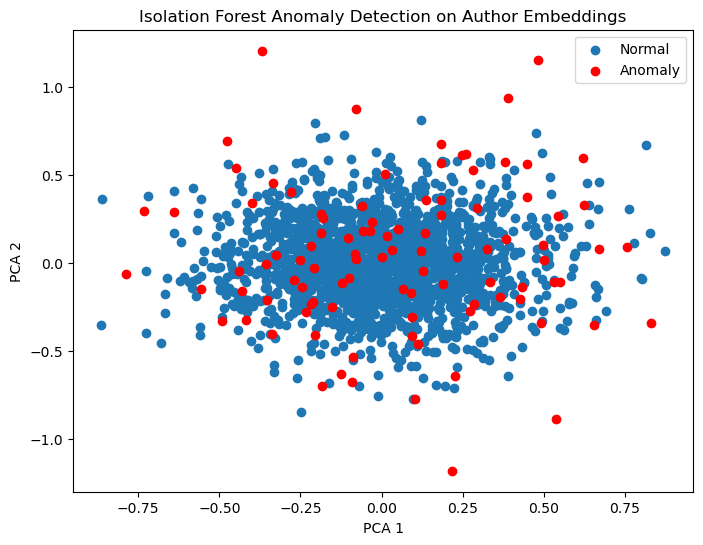

In [23]:

pca = PCA(n_components=2)
reduced = pca.fit_transform(author_vectors_real)

plt.figure(figsize=(8,6))
plt.scatter(reduced[pred == 1, 0], reduced[pred == 1, 1], label='Normal')
plt.scatter(reduced[pred == -1, 0], reduced[pred == -1, 1], label='Anomaly', color='red')
plt.legend()
plt.title("Isolation Forest Anomaly Detection on Author Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig('isolation_forest_anomaly_detection.png')
plt.show()

